# Coding for Economists - Advanced Session 2

## 1. Setup Environment

In [ ]:
%pip install tensorflow scikeras torch dash dash-cytoscape

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Turn on copy on write
pd.options.mode.copy_on_write = True

## 2. Use LSTM to Forecast US Inflation

### 2.1 Collect Data

In [3]:
# Fetch multiple FRED series
from pandas_datareader import data as pdr

start_date = '1990-01-01'
df = pdr.DataReader(['CPIAUCSL', 'UNRATE', 'FEDFUNDS'], 'fred', start=start_date)
print(df.shape)
df.head()

(424, 3)


,CPIAUCSL,UNRATE,FEDFUNDS
DATE,,,
1990-01-01,127.5,5.4,8.23
1990-02-01,128.0,5.3,8.24
1990-03-01,128.6,5.2,8.28
1990-04-01,128.9,5.4,8.26
1990-05-01,129.1,5.4,8.18


### 2.2 Preprocessing

#### Check Missing Values

In [4]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 CPIAUCSL    1
UNRATE      1
FEDFUNDS    0
dtype: int64


#### Compute Year-to-Year Inflation

In [5]:
# Compute year-on-year inflation
df = df.dropna().rename(columns={
    'CPIAUCSL': 'CPI', 'UNRATE': 'Unemployment', 'FEDFUNDS': 'FedFunds'
})
df['Inflation'] = df['CPI'].pct_change(12) * 100
df = df.dropna()
features = df[['Inflation', 'Unemployment', 'FedFunds']].values
features[:20]

array([[5.64705882, 6.4       , 6.91      ],
       [5.3125    , 6.6       , 6.25      ],
       [4.82115086, 6.8       , 6.12      ],
       [4.80993018, 6.7       , 5.91      ],
       [5.0348567 , 6.9       , 5.78      ],
       [4.69591994, 6.9       , 5.9       ],
       [4.36781609, 6.8       , 5.82      ],
       [3.7993921 , 6.9       , 5.66      ],
       [3.39622642, 6.9       , 5.45      ],
       [2.84857571, 7.        , 5.21      ],
       [3.06656694, 7.        , 4.81      ],
       [2.98062593, 7.3       , 4.43      ],
       [2.67260579, 7.3       , 4.03      ],
       [2.8189911 , 7.4       , 4.06      ],
       [3.18991098, 7.4       , 3.98      ],
       [3.18282754, 7.4       , 3.73      ],
       [3.02359882, 7.6       , 3.82      ],
       [3.01470588, 7.8       , 3.76      ],
       [3.15712188, 7.7       , 3.25      ],
       [3.07467057, 7.6       , 3.3       ]])

In [6]:
# Scale variables using Minmax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)
scaled[:20]

array([[0.69408458, 0.26315789, 1.        ],
       [0.66355373, 0.28070175, 0.90379009],
       [0.61871466, 0.29824561, 0.88483965],
       [0.6176907 , 0.28947368, 0.85422741],
       [0.63821682, 0.30701754, 0.83527697],
       [0.60728646, 0.30701754, 0.85276968],
       [0.57734467, 0.29824561, 0.84110787],
       [0.52547199, 0.30701754, 0.81778426],
       [0.48868028, 0.30701754, 0.78717201],
       [0.4387033 , 0.31578947, 0.75218659],
       [0.45859653, 0.31578947, 0.69387755],
       [0.45075381, 0.34210526, 0.63848397],
       [0.42264481, 0.34210526, 0.58017493],
       [0.4360035 , 0.35087719, 0.5845481 ],
       [0.46985255, 0.35087719, 0.5728863 ],
       [0.46920613, 0.35087719, 0.53644315],
       [0.45467539, 0.36842105, 0.54956268],
       [0.45386385, 0.38596491, 0.54081633],
       [0.46686031, 0.37719298, 0.4664723 ],
       [0.45933605, 0.36842105, 0.47376093]])

#### Prepare Input Data for LSTM
Create a list of sliding windows. At time `t`, LSTM uses past values `[t-seq_len:t-1]` to predict the current value `t`

In [7]:
# Prepare input data for LSTM
def create_sequences(data, seq_len=12):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 12 # use the past 12 months to predict the next month
X, y = create_sequences(scaled, SEQ_LEN)
print(X.shape)
print(y.shape)

(399, 12, 3)
(399,)


### 2.3 Prepare Train/Test Sets

In [8]:
# Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### 2.4 Implement ISTM and Tune the Parameters

#### Initiate the Model

In [9]:
# Model-building function for GridSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
def build_model(units=50, optimizer='adam'):
    m = Sequential([
        Input(shape=(SEQ_LEN, X.shape[2])),
        LSTM(units),
        Dense(1)
    ])
    m.compile(optimizer=optimizer, loss='mse')
    return m

In [10]:
# Wrap with KerasRegressor
from scikeras.wrappers import KerasRegressor
regressor = KerasRegressor(model=build_model, verbose=0, units=50, run_eagerly=True)

__Grid Search Space__:
- `optimizer`: Algorithm for updating weights
- `batch_size`: How many samples per gradient update
- `epochs`: Max training passes through the data

In [11]:
# Grid of hyperparameters
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [8, 16],
    'epochs': [30, 40]
}

__Split Time Series__:
>> - Split 1: train 1–20   | test 21–40
>> - Split 2: train 1–40   | test 41–60
>> - Split 3: train 1–60   | test 61–80
>> - Split 4: train 1–80   | test 81–100
>> - Split 5: train 1–100  | test (nothing left -> skip)

In [12]:
# Time series cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

#### Grid Search

In [13]:
# Grid search
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_result = grid.fit(X_train, y_train)

print("Best MSE: {:.4f}".format(-grid_result.best_score_))
print("Best Params:", grid_result.best_params_)

Best MSE: 0.0049
Best Params: {'batch_size': 8, 'epochs': 40, 'optimizer': 'adam'}


### 2.5 Predict the Historical Inflation

In [14]:
# Select the best model
best_keras_model = grid_result.best_estimator_.model_

# Predict on every available sequence in the data
hist_preds_scaled = best_keras_model.predict(X)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [15]:
# Inverse‐transform back to % inflation
hist_preds = scaler.inverse_transform(
    np.hstack([
        hist_preds_scaled.reshape(-1, 1),
        np.zeros((len(hist_preds_scaled), 2))
    ])
)[:, 0]  # get the inflation column

### 2.6 Forecast the Future 12 Months

In [16]:
# Forecast next 12 months
n_future = 12
last_seq = scaled[-SEQ_LEN:].copy()
future_preds_scaled = []

for _ in range(n_future):
    p = best_keras_model.predict(last_seq.reshape(1, SEQ_LEN, X.shape[2]))[0, 0]
    future_preds_scaled.append([p, last_seq[-1,1], last_seq[-1,2]])  # keep other features static
    last_seq = np.vstack([last_seq[1:], future_preds_scaled[-1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [17]:
# extract inflation forecasts and inverse scale
future_preds = np.array(future_preds_scaled)[:, 0].reshape(-1, 1)
inflation_preds = scaler.inverse_transform(
    np.hstack([future_preds, np.zeros((n_future, 2))])
)[:, 0]

future_dates = pd.date_range(df.index[-1], periods=n_future, freq='ME')
forecast_series = pd.Series(inflation_preds, index=future_dates)

### 2.7 Plot the Results

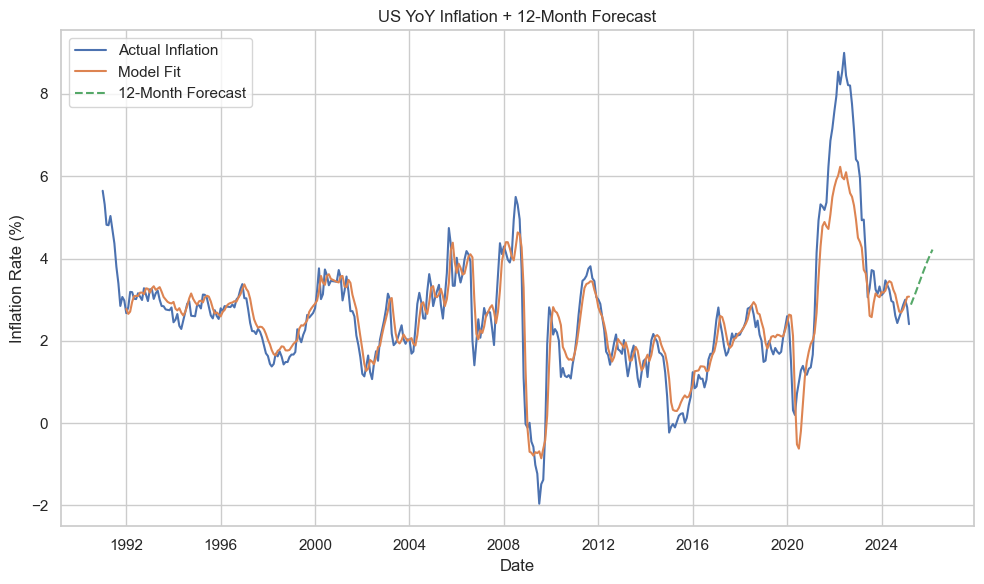

In [18]:
hist_dates = df.index[SEQ_LEN:]
historical = df['Inflation'].copy()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Actual historical inflation
sns.lineplot(x=historical.index, y=historical.values, label='Actual Inflation')

# Model’s in‐sample fit
sns.lineplot(x=hist_dates, y=hist_preds, label='Model Fit')

# 12‐month out‐of‐sample forecast (as before)
sns.lineplot(
    x=forecast_series.index,
    y=forecast_series.values,
    label='12-Month Forecast',
    linestyle='--'
)

plt.title("US YoY Inflation + 12-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
forecast_series

2025-03-31    2.880284
2025-04-30    3.001214
2025-05-31    3.123223
2025-06-30    3.251027
2025-07-31    3.384092
2025-08-31    3.516028
2025-09-30    3.645323
2025-10-31    3.772369
2025-11-30    3.894561
2025-12-31    4.011837
2026-01-31    4.122526
2026-02-28    4.218100
Freq: ME, dtype: float64

## 3. Use GNN to Build Network of US Industries

### 3.1 Load Data

In [20]:
# Load 2024 industry input–output “Use” table
io = pd.read_csv("BEA_IO_Accounts.csv", index_col=0, dtype=str, na_values=['---'])
io = io.astype(float)

# Load anual industry growth data for 2023 and 2024
df_growth = pd.read_csv("BEA_Industry_Growth.csv", index_col=0)

# Keep common industries
common_index = io.index.intersection(df_growth.index)
io     = io.loc[common_index, common_index]
df_growth = df_growth.loc[common_index]

io.head()

,Farms,"Forestry, fishing, and related activities",Oil and gas extraction,"Mining, except oil and gas",Support activities for mining,Utilities,Construction,Wood products,Nonmetallic mineral products,Primary metals,...,Educational services,Ambulatory health care services,Hospitals,Nursing and residential care facilities,Social assistance,"Performing arts, spectator sports, museums, and related activities","Amusements, gambling, and recreation industries",Accommodation,Food services and drinking places,"Other services, except government"
Farms,149222.0,183.0,NaN,45.0,21.0,NaN,3837.0,NaN,NaN,NaN,...,261.0,NaN,NaN,NaN,NaN,NaN,491.0,87.0,8378.0,13.0
"Forestry, fishing, and related activities",27934.0,9440.0,NaN,145.0,NaN,NaN,NaN,22506.0,1.0,NaN,...,63.0,NaN,NaN,NaN,NaN,NaN,404.0,438.0,7764.0,112.0
Oil and gas extraction,NaN,NaN,30944.0,11.0,83.0,29608.0,NaN,25.0,5.0,10.0,...,1291.0,42.0,8.0,18.0,38.0,17.0,232.0,31.0,19.0,161.0
"Mining, except oil and gas",1835.0,0.0,122.0,10397.0,159.0,9288.0,32790.0,10.0,16247.0,21470.0,...,655.0,NaN,27.0,42.0,475.0,474.0,951.0,168.0,1320.0,1639.0
Support activities for mining,NaN,NaN,21084.0,2085.0,1583.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_growth.head()

,Growth23,Growth24
Farms,-8.1,-10.5
"Forestry, fishing, and related activities",7.7,-4.9
Oil and gas extraction,-19.4,-6.0
"Mining, except oil and gas",6.1,1.1
Support activities for mining,13.5,-4.8


### 3.2 Preprocessing

#### Prepare Edges and Weights

In [22]:
# Build edge list & weights
edges = []
weights = []
for i, supplier in enumerate(io.index):
    for j, customer in enumerate(io.columns):
        val = io.iloc[i, j]
        if val > 0:
            edges.append((i, j))
            weights.append(val)

#### Put Data in a Tensor Object

In [23]:
import torch
from torch_geometric.data import Data
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape [2, E]
edge_attr  = torch.tensor(weights, dtype=torch.float).unsqueeze(1)   # [E,1]

# Node features: last-year’s value-added growth 
x = torch.tensor(df_growth.Growth23.values.reshape(-1,1), dtype=torch.float)

# Target: this year’s growth
y = torch.tensor(df_growth.Growth24.values, dtype=torch.float)

# Put together
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

### 3.3 Build the Network Using GNN

#### Initiate the GNN Model

In [24]:
# Define a two–layer GCN
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class IO_GCN(torch.nn.Module):
    def __init__(self, in_feats, hidden=16):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden)
        self.conv2 = GCNConv(hidden, 1)
    def forward(self, data):
        h = F.relu(self.conv1(data.x, data.edge_index, data.edge_attr))
        h = self.conv2(h, data.edge_index, data.edge_attr).squeeze()
        return h

model = IO_GCN(in_feats=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = torch.nn.MSELoss()

#### Get the Train/Test Indices

In [25]:
# Train/test split (e.g. 80/20 on nodes)
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8*num_nodes)]
test_idx  = perm[int(0.8*num_nodes):]

#### Train the Model

In [26]:
# Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    if epoch%50==0:
        print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}")

Epoch 000  Loss: 26.8153
Epoch 050  Loss: 25.4460
Epoch 100  Loss: 24.4293
Epoch 150  Loss: 23.9502
Epoch 200  Loss: 23.6789
Epoch 250  Loss: 23.4495
Epoch 300  Loss: 23.2481
Epoch 350  Loss: 23.1008
Epoch 400  Loss: 22.9993
Epoch 450  Loss: 22.9379
Epoch 500  Loss: 22.9011
Epoch 550  Loss: 22.8794
Epoch 600  Loss: 22.8469
Epoch 650  Loss: 22.7997
Epoch 700  Loss: 22.7752
Epoch 750  Loss: 22.7516
Epoch 800  Loss: 22.7328
Epoch 850  Loss: 22.7142
Epoch 900  Loss: 22.6961
Epoch 950  Loss: 22.6789


#### Evaluate the Trained Model

In [27]:
# Evaluate
model.eval()
preds = model(data).detach()
mse = loss_fn(preds[test_idx], data.y[test_idx])
print(f"\nTest MSE: {mse:.4f}")


Test MSE: 31.7169


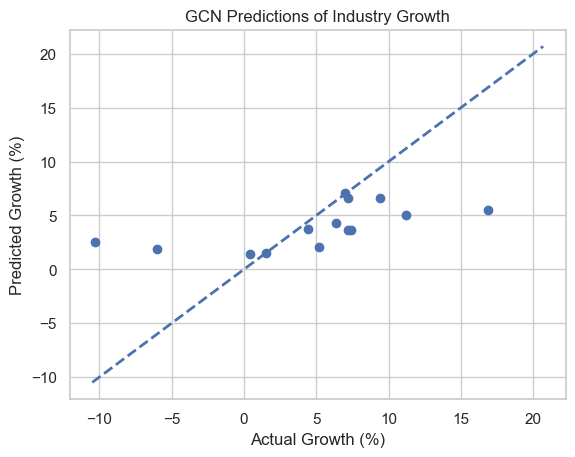

In [28]:
# Compare the predicted growth and actual growth
import matplotlib.pyplot as plt
plt.scatter(data.y[test_idx], preds[test_idx])
plt.plot([data.y.min(), data.y.max()],
         [data.y.min(), data.y.max()], '--', lw=2)
plt.xlabel("Actual Growth (%)")
plt.ylabel("Predicted Growth (%)")
plt.title("GCN Predictions of Industry Growth")
plt.show()

#### Plot the Network

In [29]:
from torch_geometric.utils import to_networkx

# Convert to a NetworkX graph
G = to_networkx(
    data,
    node_attrs=[],       
    edge_attrs=[],
    to_undirected=True    
)

edge_index = data.edge_index.t().tolist() 
weights     = data.edge_attr.squeeze().tolist()
for (u, v), w in zip(edge_index, weights):
    G[u][v]['weight'] = float(w)   

In [30]:
# Filter edges: no self-loops, top 2% by weight
all_edges   = [(u, v, d) for u, v, d in G.edges(data=True) if u != v]
all_weights = [d['weight'] for _, _, d in all_edges]
threshold   = np.percentile(all_weights, 98) 

important_edges = [
    (u, v, d) for u, v, d in all_edges
    if d['weight'] >= threshold
]

In [31]:
# Build subgraph of just those edges & their nodes
important_nodes = set()
for u, v, _ in important_edges:
    important_nodes.update([u, v])

G_sub = G.subgraph(important_nodes).copy()

In [32]:
# Build Cytoscape “elements” list
elements = []

# nodes
for node in G_sub.nodes():
    elements.append({
        'data': {
            'id': str(node),
            'label': common_index[node] 
        }
    })

# edges
for u, v, d in important_edges:
    elements.append({
        'data': {
            'source': str(u),
            'target': str(v),
            'weight': d['weight']
        }
    })
elements[:40]

[{'data': {'id': '0', 'label': 'Farms'}},
 {'data': {'id': '6', 'label': 'Construction'}},
 {'data': {'id': '7', 'label': 'Wood products'}},
 {'data': {'id': '8', 'label': 'Nonmetallic mineral products'}},
 {'data': {'id': '10', 'label': 'Fabricated metal products'}},
 {'data': {'id': '11', 'label': 'Machinery'}},
 {'data': {'id': '13',
   'label': 'Electrical equipment, appliances, and components'}},
 {'data': {'id': '18', 'label': 'Food and beverage and tobacco products'}},
 {'data': {'id': '23', 'label': 'Petroleum and coal products'}},
 {'data': {'id': '24', 'label': 'Chemical products'}},
 {'data': {'id': '25', 'label': 'Plastics and rubber products'}},
 {'data': {'id': '26', 'label': 'Wholesale trade'}},
 {'data': {'id': '30', 'label': 'Other retail'}},
 {'data': {'id': '34', 'label': 'Truck transportation'}},
 {'data': {'id': '37',
   'label': 'Other transportation and support activities'}},
 {'data': {'id': '42',
   'label': 'Data processing, internet publishing, and other info

In [33]:
# Create the Dash app
import dash
from dash import html
import dash_cytoscape as cyto

app = dash.Dash(__name__)
app.layout = html.Div([
    html.H3("Industry I/O Network (Top 2% Flows, No Self-Loops)"),
    cyto.Cytoscape(
        id='cytoscape-network',
        elements=elements,
        layout={'name': 'cose'},     
        style={'width': '100%', 'height': '700px'},
        stylesheet=[
            # nodes: wrap truncated label, small font
            {
                'selector': 'node',
                'style': {
                    'content':         'data(label)',
                    'text-wrap':       'wrap',
                    'text-max-width':  80,
                    'font-size':       '8px',
                    'background-color':'#67a9cf',
                    'width':           '20px',
                    'height':          '20px'
                }
            },
            {
                'selector': 'node',
                'style': {
                    'label': 'data(label)',
                    'background-color': '#67a9cf',
                    'width': 20,
                    'height': 20,
                    'font-size': '10px',
                    'text-valign': 'center',
                    'text-halign': 'center'
                }
            },
            {
                'selector': 'edge',
                'style': {
                    # map weight (0→max) to line-width 1→8
                    'width': f"mapData(weight, 0, {max(all_weights)}, 1, 8)",
                    'line-color': '#888',
                    'curve-style': 'bezier'
                }
            }
        ]
    )
])

if __name__ == '__main__':
    app.run(debug=False)